In [38]:
from math import prod

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.datasets import MNIST

In [2]:
train_data = MNIST(root="data/", train=True, download=True)

In [3]:
class NoiseScheduler:
    def __init__(self, T = 1000, beta_min = 1e-4, beta_max = 0.02):
        self.T = T
        self.beta_min = beta_min
        self.beta_max = beta_max

    def get_beta_t(self, t):
        # Linear noise-scaling
        beta_t = self.beta_min + (t / self.T) * (self.beta_max - self.beta_min)
        return beta_t

    def get_alpha_t(self, t):
        beta_t = self.get_beta_t(t)
        alpha_t = 1.0 - beta_t
        return alpha_t

    def get_alpha_hat_t(self, t):
        alphas = [self.get_alpha_t(s) for s in range(1, t + 1)]
        alpha_hat = prod(alphas)
        return alpha_hat

    def add_noise(self, x_o, t):
        if t == 0:
            return x_o

        alpha_t = self.get_alpha_hat_t(t)
        epsilon = np.random.normal(
            loc=0, scale=np.sqrt(1.0 - alpha_t), size=x_o.shape
        )

        return np.sqrt(alpha_t) * x_o + epsilon

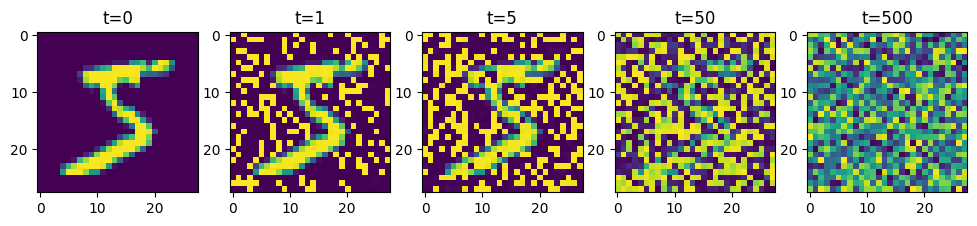

In [4]:
class Scaling:
    @staticmethod
    def transform(img):
        t_img = np.asarray(img) / 255
        t_img = t_img * 2 - 1
        return t_img

    @staticmethod
    def inverse_transform(output):
        output = (output + 1) / 2
        output = output * 255
        output = np.uint8(output)
        noise_img = Image.fromarray(output)
        return noise_img


Ts = [0, 1, 5, 50, 500]
scheduler = NoiseScheduler()
img = train_data[0][0]

f, axarr = plt.subplots(1, len(Ts), figsize=(12,6))

for idx, t in enumerate(Ts):
    o = scheduler.add_noise(Scaling.transform(img), t)
    axarr[idx].imshow(Scaling.inverse_transform(o))
    axarr[idx].set_title(f"t={t}")

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_dims):
        super().__init__()
        self.num_dims = num_dims

    def forward(self, t):
        # NOTE: t need to be of shape [batch_size, 1]
        d = self.num_dims // 2
        i = torch.arange(0, d)
        i = i.unsqueeze(0)
        div_term = 1 / (10000 **((i / (d - 1))))
        emb = t / div_term
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)        
        return emb


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class TimeEmbedding(nn.Module):
    def __init__(self, time_dim):
        super().__init__()

        self.pe = PositionalEncoding(time_dim)
        self.linear = nn.Linear(time_dim, time_dim)
        self.act = Swish()

    def forward(self, t):
        p = self.pe(t)
        p = self.linear(p)
        p = self.act(p)
        return p


class Block(nn.Module):
    def __init__(self, in_channels, out_channels, groups=8):
        super().__init__()

        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.gn = nn.GroupNorm(num_groups=groups, num_channels=out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.gn(x)
        x = self.act(x)
        return x


class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block_1 = Block(in_channels, out_channels)
        self.block_2 = Block(out_channels, out_channels)
        self.time_emb = TimeEmbedding(out_channels)

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, t):
        h = self.block_1(x)
        h += self.time_emb(t)[:, :, None, None]
        h = self.block_2(h)

        return h + self.shortcut(x)

In [55]:
dummy_x = torch.randn((64, 16, 14, 14))
dummy_t = torch.randint(0, 256, size=(64, 1))

m = ResNetBlock(16, 32)
m(dummy_x, dummy_t).shape

torch.Size([64, 32, 14, 14])